In [1]:
# # For Google Colab
# %pip install sodapy
# %pip install python-dotenv

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
import multiprocess as mp
from dotenv import load_dotenv
load_dotenv()

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

from sodapy import Socrata

from tqdm.notebook import tqdm
tqdm.pandas()

# Predicting SLA Violations of NYC311 Requests

This analysis leverages data from NYC Open Data sources:
1. **[311 Service Requests from 2010 to Present](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9):** provides 311 reporting as far back as 2010, and is updated on an automated daily basis. Each record in this dataset corresponds to a 311 service request.
2. **[311 Service Level Agreements](https://data.cityofnewyork.us/City-Government/311-Service-Level-Agreements/cs9t-e3x8):** Provides the time commitments that City Agencies have made to respond to 311 Service Requests that are assigned to them.

## Data Ingestion

In [3]:
reports = pd.read_parquet("data/311_reports_2023_embeddings.parquet")
reports.shape

(1463148, 308)

## Data Engineering

In [4]:
reports.groupby('agency_name').breached.agg(['count', 'sum', 'mean'])

,count,sum,mean
agency_name,,,
Department of Consumer Affairs,7631,80,0.010484
Department of Education,949,381,0.401475
Department of Health and Mental Hygiene,22810,714,0.031302
Department of Homeless Services,22,9,0.409091
Department of Parks and Recreation,61940,21489,0.346933
Department of Sanitation,169465,62504,0.368831
Department of Transportation,70371,10402,0.147817
New York City Police Department,1108494,37894,0.034185
Taxi and Limousine Commission,21466,14392,0.670456


### Dimensionality Reduction

In [5]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [6]:
embeddings = reports[reports.columns[reports.columns.str.startswith('e')]]

Text(0.5, 1.0, 'Cumulative Explained Variance Ratio vs. # Components')

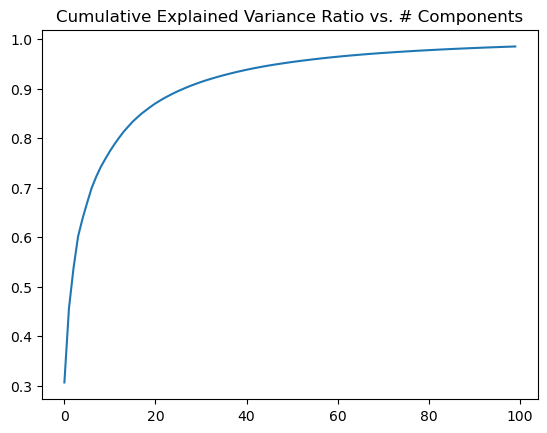

In [7]:
pca = PCA(n_components=100)
pca.fit(embeddings)
plt.plot(range(100), np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative Explained Variance Ratio vs. # Components")

Looks like marginal benefit starts to plateau ~25 components

## Modeling

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer

from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, cross_validate#, GridSearchCV, RandomizedSearchCV

Let's take a departure here and randomly sample like 400k rows, stratified by agency name

In [9]:
# df = reports[reports.agency_name=="Department of Sanitation"].copy()
# df = df.drop(columns=['agency_name'])

In [10]:
n_samples = 250000
df = reports.groupby('agency_name').apply(lambda g: g.sample(round(n_samples * len(g) / len(reports)))).reset_index(drop=True)
df['agency_name'] = df.agency_name.astype('category')

In [11]:
X = df.loc[:, ~df.columns.isin(['breached'])]
y = df.breached.astype(int)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

### Pipeline

In [13]:
encoder_scaler = ColumnTransformer(transformers=[
    ('OneHot', OneHotEncoder(), ['open_data_channel_type']),
    ('scaler', StandardScaler(), X_train.select_dtypes([int, float]).columns)
])

In [14]:
reduce_dim = ColumnTransformer(transformers=[
    ('reduce_dim', PCA(n_components=25), list(range(10, 310)))
])

In [15]:
def model_quicktest(estimator, preprocess=True, returns_proba=True):

    if preprocess:
        pipeline = Pipeline(steps=[
            ('encoder_scaler', encoder_scaler),
            ('reduce_dim', reduce_dim),
            ('imputer', KNNImputer()),
            ('clf', estimator)
        ])
    else:
        pipeline = Pipeline(steps=[
            ('clf', estimator)
        ])

    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    if returns_proba:
        scoring.append('neg_log_loss')
    results = cross_validate(estimator=pipeline, X=X_train, y=y_train,
                             scoring=scoring,
                             cv=5, n_jobs=-1)
    
    print('Average accuracy:', results['test_accuracy'].mean())
    print('Average F1 score:', results['test_f1'].mean())
    print('Average AUC of ROC Curve:', results['test_roc_auc'].mean())
    if returns_proba:
        print(f"Avg Log Loss: {-results['test_neg_log_loss'].mean()}")

### Model Selection

In [16]:
%%time
model_quicktest(LogisticRegressionCV(n_jobs=-1, max_iter=100000))

Average accuracy: 0.9024000000000001
Average F1 score: 0.26920462919778887
Average AUC of ROC Curve: 0.8300184524389234
Avg Log Loss: 0.2520294723856564
CPU times: user 57.7 ms, sys: 127 ms, total: 185 ms
Wall time: 13.4 s


In [17]:
%%time
model_quicktest(LinearSVC(max_iter=100000, dual='auto'),
                returns_proba=False)

Average accuracy: 0.8991200000000001
Average F1 score: 0.15742556586340087
Average AUC of ROC Curve: 0.8247027327655477
CPU times: user 38.6 ms, sys: 86.3 ms, total: 125 ms
Wall time: 7.95 s


In [18]:
%%time
model_quicktest(KNeighborsClassifier())

Average accuracy: 0.9214933333333333
Average F1 score: 0.5524414300834696
Average AUC of ROC Curve: 0.8416670633282909
Avg Log Loss: 1.0092233422017394
CPU times: user 39.4 ms, sys: 78 ms, total: 117 ms
Wall time: 31 s


In [19]:
%%time
model_quicktest(GaussianNB())

Average accuracy: 0.8380600000000001
Average F1 score: 0.4151588685881352
Average AUC of ROC Curve: 0.7931192212349231
Avg Log Loss: 0.7146761682874729
CPU times: user 39.6 ms, sys: 90 ms, total: 130 ms
Wall time: 7.42 s


In [20]:
%%time
model_quicktest(LinearDiscriminantAnalysis())

Average accuracy: 0.8954733333333333
Average F1 score: 0.43933464899670194
Average AUC of ROC Curve: 0.8228781778016202
Avg Log Loss: 0.28242409069099506
CPU times: user 40.8 ms, sys: 96.3 ms, total: 137 ms
Wall time: 7.71 s


In [21]:
# %%time
# model_quicktest(SVC(kernel='rbf'), returns_proba=False)

In [22]:
%%time
model_quicktest(RandomForestClassifier(random_state=42))

Average accuracy: 0.9219666666666667
Average F1 score: 0.540606008531517
Average AUC of ROC Curve: 0.8812579538369667
Avg Log Loss: 0.3422558385099696
CPU times: user 40.1 ms, sys: 86.3 ms, total: 126 ms
Wall time: 1min 52s


In [23]:
%%time
model_quicktest(xgb.XGBClassifier(objective='binary:logistic'))

Average accuracy: 0.9244266666666666
Average F1 score: 0.5485289833721392
Average AUC of ROC Curve: 0.8935167334284314
Avg Log Loss: 0.2062819720496943
CPU times: user 39.6 ms, sys: 67.4 ms, total: 107 ms
Wall time: 8.42 s


In [24]:
%%time
model_quicktest(xgb.XGBClassifier(objective='binary:logistic', enable_categorical=True),
                preprocess=False)

Average accuracy: 0.9291933333333333
Average F1 score: 0.5929023330674952
Average AUC of ROC Curve: 0.9265106145432667
Avg Log Loss: 0.18263690478511269
CPU times: user 37.9 ms, sys: 77.6 ms, total: 116 ms
Wall time: 21.7 s


In [25]:
%%time
model_quicktest(CatBoostClassifier(cat_features=[0, 1], verbose=0),
                preprocess=False)

Average accuracy: 0.9325066666666666
Average F1 score: 0.6075652219592925
Average AUC of ROC Curve: 0.9300223865751974
Avg Log Loss: 0.17712871685566672
CPU times: user 45.1 ms, sys: 51.7 ms, total: 96.8 ms
Wall time: 3min 37s


### Hyperparameter Tuning

The mathematical definition of XGBoost's objective function at the $t$-th iteration is given by:

$$
\mathcal{L}^{(t)} = \sum_{i=1}^{n} \ell \left( y_i, \hat{y}_i^{(t-1)} \right) + f_t \left( \mathbf{x}_i \right) + \Omega(f_t)
$$

- $\ell(y_i, \hat{y}_i^{(t-1)})$: loss function (log-loss) which measures the discrepancy between the predicted value $\hat{y}_i^{(t-1)}$ and the actual label $y_i$ for the $i$-th instance.
- $f_t(\mathbf{x}_i)$: score given by the $t$-th tree for the $i$-th instance with feature vector $\mathbf{x}_i$.
- $\Omega(f_t)$: regularization term for the $t$-th tree to penalize model complexity.


The objective function combines both the fidelity of the model to the data, through the loss function, and the complexity of the model, through the regularization term. The loss function is typically a convex function such as the squared error for regression or logistic loss for classification tasks, and the regularization term is used to control overfitting by penalizing the number of leaves and the magnitude of the leaf weights.


Reference:
- https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning#2.-XGBoost-hyperparameters-
- https://xgboost.readthedocs.io/en/stable/python/python_api.html

In [26]:
from hyperopt import tpe, hp, fmin, Trials, STATUS_OK

In [27]:
# For reference
default_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.3,
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'colsample_bytree': 1,
    'min_child_weight': 1
}

# Search space
params = {
    'model__n_estimators' : hp.quniform('n_estimators', 125, 129, 1),
    'model__learning_rate' : hp.uniform('learning_rate', 0.33, 0.34),
    'model__max_depth' : hp.quniform('max_depth', 6, 10, 1),
    'model__gamma': hp.uniform('gamma', 1, 2),
    'model__reg_alpha' : hp.quniform('reg_alpha', 0, 10, 1),
    'model__reg_lambda' : hp.uniform('reg_lambda', 1., 1.2),
    'model__subsample': hp.uniform('subsample', 0.92, 0.98),
    'model__colsample_bytree' : hp.uniform('colsample_bytree', 0.9, 0.92),
    'model__min_child_weight' : hp.quniform('min_child_weight', 1, 4, 1),
}

In [28]:
# Defining Objective function whose loss we have to minimize
def objective(params):
    
    # Initialize model pipeline
    pipeline = Pipeline(steps=[
        ('model', xgb.XGBClassifier(objective='binary:logistic',
                                    # scale_pos_weight=len(y[y==0]) / y.sum(),
                                    enable_categorical=True))
    ])
    # Model parameters will be set here
    params['model__n_estimators'] = int(params['model__n_estimators'])
    params['model__max_depth'] = int(params['model__max_depth'])
    pipeline.set_params(**params)
    
    # Cross Validation Score. Note the transformer.fit_transform for X_train.
    results = cross_validate(estimator=pipeline, X=X_train, y=y_train,
                             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'neg_log_loss'],
                             cv=5, n_jobs=-1)
          
    # Since we have to minimize the score, we return 1- score.
    return {'loss': -results['test_f1'].mean(), 'status': STATUS_OK}

In [29]:
# Hyperopts Trials() records all the model and run artifacts.
trials = Trials()

# Fmin will call the objective funbction with selective param set. 
# The choice of algorithm will narrow the searchspace.
argmin = fmin(fn=objective,
              space=params,
              algo=tpe.suggest,
              max_evals=200,
              trials=trials)

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [1:38:07<00:00, 29.44s/trial, best loss: -0.6066221001312326]


In [30]:
argmin['n_estimators'] = int(argmin['n_estimators'])
argmin['max_depth'] = int(argmin['max_depth'])
argmin

{'colsample_bytree': 0.9045625497798042,
 'gamma': 1.267995573468346,
 'learning_rate': 0.3392225292613463,
 'max_depth': 7,
 'min_child_weight': 4.0,
 'n_estimators': 129,
 'reg_alpha': 5.0,
 'reg_lambda': 1.0362229854426441,
 'subsample': 0.9291639427494334}

**Feature Importances**

In [31]:
# feature_importance = pd.concat([pd.Series(clf.feature_names_in_, name='feature'),
#                                 pd.Series(clf['clf'].feature_importances_, name='feature_importance')], axis=1)\
#                         .sort_values(by='feature_importance', ascending=False)
# feature_importance

## Training

In [32]:
clf = xgb.XGBClassifier(objective='binary:logistic', enable_categorical=True,
                        # scale_pos_weight=len(y[y==0]) / y.sum(),
                        **argmin)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9045625497798042, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, feature_types=None, gamma=1.267995573468346,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3392225292613463,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=4.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=129, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Evaluation

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score, accuracy_score, roc_curve, log_loss
from sklearn import metrics

In [34]:
def plot_roc_pr(y_true, y_pred_proba, estimator_name='xgboost'):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = metrics.auc(fpr, tpr)
    roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                          estimator_name=estimator_name)
    
    # PR Curve
    precision, recall, _ = metrics.precision_recall_curve(y_true, y_pred_proba)
    pr_auc = metrics.average_precision_score(y_true, y_pred_proba)
    pr_display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=pr_auc,
                                                estimator_name=estimator_name)
    
    roc_display.plot(ax=ax1)
    pr_display.plot(ax=ax2)

#### Train

In [35]:
y_pred = clf.predict(X_train)
y_pred_proba = clf.predict_proba(X_train)[:, 1]

In [36]:
print(classification_report(y_train, y_pred))
print(f"Log Loss: {log_loss(y_train, y_pred_proba)}")

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    134770
           1       0.94      0.78      0.86     15230

    accuracy                           0.97    150000
   macro avg       0.96      0.89      0.92    150000
weighted avg       0.97      0.97      0.97    150000

Log Loss: 0.08318126767567517


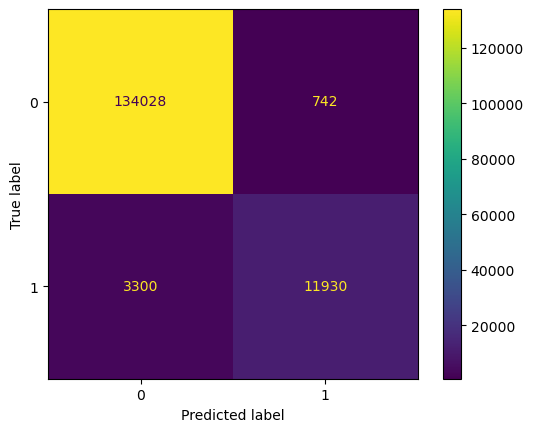

In [37]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred)).plot()

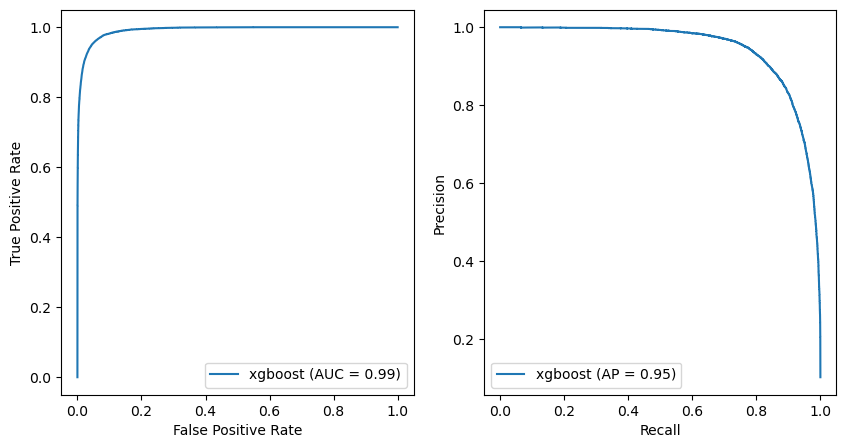

In [38]:
plot_roc_pr(y_train, y_pred_proba)

### Test

In [39]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

In [40]:
print(classification_report(y_test, y_pred))
print(f"Log Loss: {log_loss(y_test, y_pred_proba)}")

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     44924
           1       0.71      0.54      0.61      5076

    accuracy                           0.93     50000
   macro avg       0.83      0.76      0.79     50000
weighted avg       0.92      0.93      0.93     50000

Log Loss: 0.1833270060010565


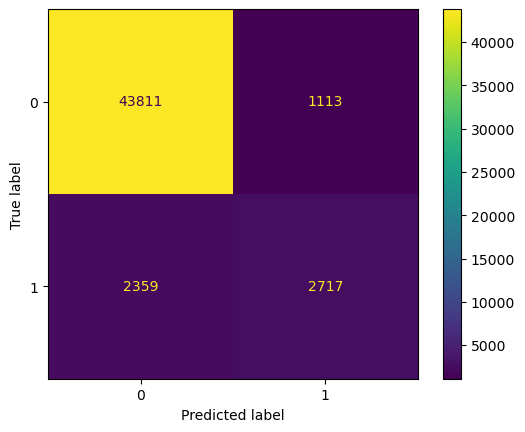

In [41]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

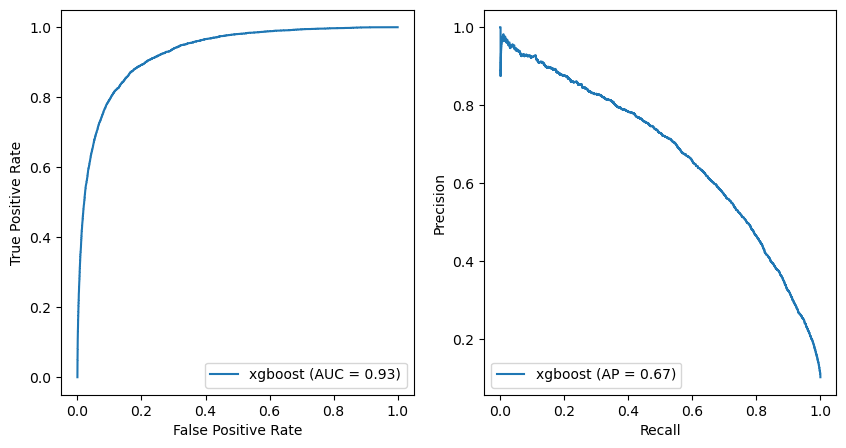

In [42]:
plot_roc_pr(y_test, y_pred_proba)

#### Department of Transportation (DOT)

In [68]:
idx = X_test[X_test.agency_name=="Department of Transportation"].index
X_dot = X_test.loc[idx]
y_dot = y_test.loc[idx]
X_dot.shape

(2299, 307)

In [64]:
y_pred = clf.predict(X_dot)
y_pred_proba = clf.predict_proba(X_dot)[:, 1]

In [65]:
print(classification_report(y_dot, y_pred))
print(f"Log Loss: {log_loss(y_dot, y_pred_proba)}")

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1953
           1       0.70      0.38      0.49       346

    accuracy                           0.88      2299
   macro avg       0.80      0.68      0.71      2299
weighted avg       0.87      0.88      0.87      2299

Log Loss: 0.3301818686301924


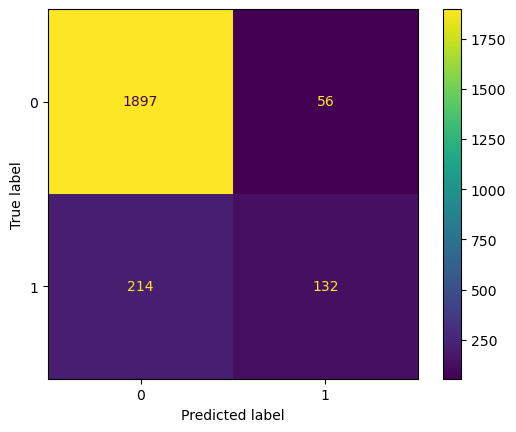

In [66]:
ConfusionMatrixDisplay(confusion_matrix(y_dot, y_pred)).plot()

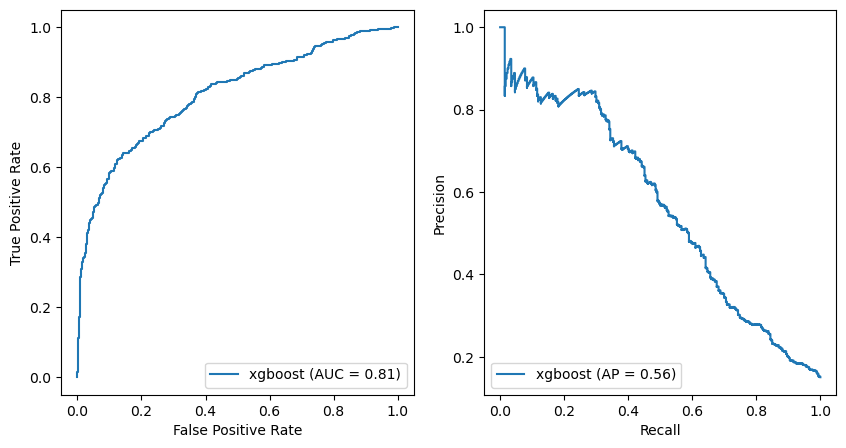

In [67]:
plot_roc_pr(y_dot, y_pred_proba)

## Calibration

Let's check if we need to calibrate our probabilities:

Reference: https://scikit-learn.org/stable/modules/calibration.html

In [43]:
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV

In [48]:
y_pred = clf.predict(X_calib)
y_pred_proba = clf.predict_proba(X_calib)[:, 1]

Text(0.5, 1.0, 'Calibration Curve')

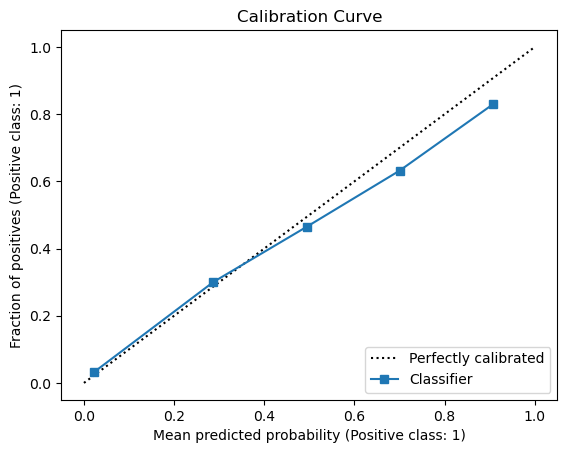

In [49]:
CalibrationDisplay.from_predictions(y_calib, y_pred_proba)
plt.title(f"Calibration Curve")

In [51]:
X_calib.shape

(50000, 307)